# Subbundles Part 3: Streamline Profiles

**Subbundle** - a subgroup of streamlines with a set of common properties

Part 3: Get streamline profiles for tissue properties `fa_values` and `md_values`

In [1]:
from utils import get_tractogram_filename, get_scalar_filename

import os.path as op

import numpy as np

from dipy.io.streamline import load_tractogram
from dipy.tracking.streamline import set_number_of_points, values_from_volume

import nibabel as nib

from AFQ import api
import AFQ.data as afd

import matplotlib.pyplot as plt

/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Streamlines (from Part 2)

#### AFQ

- Instantiate AFQ object: `myafq` for desired dataset

- get `row` from `myafq` to interact with api

In [2]:
myafq = api.AFQ(
    bids_path=op.join(afd.afq_home, 'stanford_hardi'),
    dmriprep='vistasoft'
)

row = myafq.data_frame.iloc[0]

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/subbundles/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [3]:
bundle_name='SLF_L'
tg_fname = tg_fname = get_tractogram_filename(myafq, bundle_name)
tractogram = load_tractogram(tg_fname, 'same')
streamlines = tractogram.streamlines
affine = tractogram.affine

## Generate Streamline Tract Profiles

<span style="color:blue">**TODO: Quantify *Stability* and *Robustness* of resulting tract profiles**</span>

- <span style="color:red">**Question: How to quantify these properties?**</span>

### Streamline Tract Profile Metrics

Calculate Streamline Tract Profiles, using:

- (DTI/DKI) Tissue Properties

  - Other Tissue Properties

- (Geometrically Constrained) Distance

#### (DTI/DKI) Tissue Properties:

  - **[FA](https://en.wikipedia.org/wiki/Fractional_anisotropy) (*Fractional Anisotropy*)**
  
  - **MD (*Mean Diffusivity*)**
  
  - APM (*Anisotropic Power Map*)


#### (Geometrically Constrained) Distance:

  - Euclidean
  
  - QuickBundle MDF (*Minimum Average Direct Flip*)


##### Other Tissue Properties:

- [Relaxometry](https://radiopaedia.org/articles/relaxometry?lang=us)-based parameter


- Quantitative T<sub>1</sub> (**NOTE: May not exist for HCP dataset**)
  
- T<sub>1</sub>/T<sub>2</sub> ratio (**NOTE: May not exist for HARDI dataset**)
    
    
- quantitative measures (T<sub>1</sub>, T<sub>2</sub>, T<sub>2</sub>*)
  
- semi-quantitative measures (T<sub>2</sub>-weighted/T<sub>1</sub>-weighted ratio (T<sub>2</sub>w/T<sub>1</sub>w))


### Get Tissue Properties (Scalar Data)

#### Diagnostic information:

In [4]:
print(set(len(streamline) for streamline in streamlines))

{103, 107, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177, 178, 187, 190, 193, 195, 196, 197, 198, 199, 202, 203, 204, 207, 208, 209, 210, 211, 212, 213, 214, 225, 249}


<span style="color:blue">**TODO: Automatically use all available scalars**</span>

#### FA

In [5]:
fa_scalar_file = get_scalar_filename(myafq, 'DTI_FA')

print(fa_scalar_file)

fa_scalar_data = nib.load(fa_scalar_file).get_fdata()

/Users/bloomdt/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/sub-01_ses-01_dwi_model-DTI_FA.nii.gz


#### MD

In [6]:
md_scalar_file = get_scalar_filename(myafq, 'DTI_MD')

print(md_scalar_file)

md_scalar_data = nib.load(md_scalar_file).get_fdata()

/Users/bloomdt/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/sub-01_ses-01_dwi_model-DTI_MD.nii.gz


## Streamline Profiles

Calculate tissue properties per streamline

For reference:
- https://github.com/dipy/dipy/blob/master/dipy/tracking/streamline.py#L668

  - https://github.com/dipy/dipy/blob/master/dipy/stats/analysis.py#L221

### Streamline Profile

## <span style="color:red">NOTE: Streamlines do not have the same length</span>

- There are several approaches to align streamlines, and these choices can affect results.

  - Default is to sample uniform number of points from each streamline
  
    - While this allows for comparison across streamlines, it also will warp distance.
    
    - This could mean that if there are short and long streamlines the short streamline may align to a segment of the long streamline, but the streamline profile will not capture this.
    

- Some of the above concerns may be addressed downstream when clustering by adding additional metrics:

  - Incorporate geometric distance
  
  - Incorporate streamline profiles for different streamline alignments
  
<span style="color:blue">**TODO: Incorporate streamline inteperpolation/alignment aglorithm from @arokem**</span>

## <span style="color:red">NOTE: By default sampling `100` points from each streamline</span>

- The choice of `n_points` by convenction, however want to ensure it is greater than minimum number in `streamlines`.

For comparison (see Diffusion profile realignment (dpr)):

https://github.com/samuelstjean/dpr

In [7]:
n_points = 100
fgarray = set_number_of_points(streamlines, n_points)

<span style="color:blue">**TODO: Automatically use all available scalars**</span>

#### FA

In [8]:
fa_values = np.array(values_from_volume(fa_scalar_data, fgarray, affine))
print(fa_values)

[[0.21622381 0.2705829  0.33299403 ... 0.25920407 0.27066547 0.20629653]
 [0.20348186 0.24565254 0.30600664 ... 0.28250741 0.24818694 0.21115255]
 [0.20385597 0.23191743 0.26918901 ... 0.27723545 0.26349754 0.2273314 ]
 ...
 [0.2234561  0.29100039 0.3102349  ... 0.32232922 0.2835963  0.22808719]
 [0.22813402 0.26913598 0.27248162 ... 0.27560819 0.24418002 0.21394383]
 [0.20290428 0.23889827 0.26283582 ... 0.34387642 0.30092561 0.21896093]]


In [9]:
print(fa_values.shape)
print(len(fa_values)==len(streamlines))

(465, 100)
True


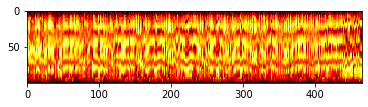

In [10]:
plt.imshow(fa_values.T, cmap='hot', interpolation='nearest')
plt.show()

In [11]:
np.save('fa_streamline_profile.npy', fa_values)

#### MD

[[0.00068196 0.00063612 0.00060533 ... 0.00069803 0.00066405 0.00052528]
 [0.00069071 0.00065561 0.00061652 ... 0.00073039 0.00072237 0.00072529]
 [0.00070633 0.00066386 0.00062062 ... 0.00067385 0.00069238 0.00070819]
 ...
 [0.00073598 0.00070669 0.00068053 ... 0.00066011 0.00066077 0.00059115]
 [0.00068931 0.00069455 0.00072064 ... 0.00068263 0.00069299 0.00070179]
 [0.000718   0.00071364 0.00068103 ... 0.00065929 0.0006614  0.0005453 ]]
(465, 100)
True


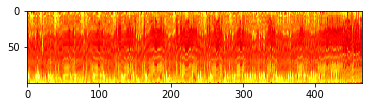

In [12]:
md_values = np.array(values_from_volume(md_scalar_data, fgarray, affine))
print(md_values)
print(md_values.shape)
print(len(md_values)==len(streamlines))
plt.imshow(md_values.T, cmap='hot', interpolation='nearest')
plt.show()
np.save('md_streamline_profile.npy', md_values)